# 01c pool HSC and MPP1 preprocessing

to especially compare HSCs and MPP1 in dmPGE2 and ct

docker run 
--rm 
-d 
--name scanpy2 
-p 8880:8888 
-e JUPYTER_ENABLE_LAB=YES 
-v /Users/efast/Documents/:/home/jovyan/work 
scanpy:1.4.6

## 1) Loading packages + data

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sb

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

## Load LTs

In [3]:
# Set up data loading

#Data files
sample_strings = ['ct', 'dmPGE2', 'GCSF', 'indo', 'pIC']
sample_id_strings = ['A_ct', 'A_dmPGE2', 'A_GCSF', 'A_indo', 'A_pIC']

file_base = './raw_data/'
file_end = '/outs/filtered_feature_bc_matrix'

In [4]:
# First data set load & annotation
#Parse Filenames
sample = sample_strings.pop(0) # this pops out the first element of the list sample_strings = ct
sample_id = sample_id_strings.pop(0) # this pops out the first element of the list sample_id_strings = 1
data_file = file_base+sample_id+file_end # assembles the name of the datafile

#Load data
adata = sc.read_10x_mtx(data_file, var_names='gene_symbols', cache=True)

#Annotate data
adata.obs['sample'] = [sample]*adata.n_obs #this multiplies ct*the number of adata.n_obs and adds it into the adata.obs df

... reading from cache file cache/raw_data-A_ct-outs-filtered_feature_bc_matrix-matrix.h5ad


In [5]:
# Loop to load rest of data sets
for i in range(len(sample_strings)):
    #Parse Filenames
    sample = sample_strings[i] # this pops out the first element of the list sample_strings = ct
    sample_id = sample_id_strings[i] # this pops out the first element of the list sample_id_strings = 1
    data_file = file_base+sample_id+file_end # assembles the name of the datafile
     
    #Load data
    adata_tmp = sc.read_10x_mtx(data_file, var_names='gene_symbols', cache=True)
    
    #Annotate data
    adata_tmp.obs['sample'] = [sample]*adata_tmp.n_obs

    adata_tmp.var_names_make_unique()

    # Concatenate to main adata object
    adata = adata.concatenate(adata_tmp, batch_key='sample_id') #batch_key is identifying the sample
    adata.obs.drop(columns=['sample_id'], inplace=True) #drops the ID - the number
    adata.obs_names = [c.split("-")[0] for c in adata.obs_names] #adata.obs_names accesses the index of adata.obs = the barcodes
    # this removes the "-1"
    adata.obs_names_make_unique(join='_') #makes the cell barcodes unique

... reading from cache file cache/raw_data-A_dmPGE2-outs-filtered_feature_bc_matrix-matrix.h5ad
... reading from cache file cache/raw_data-A_GCSF-outs-filtered_feature_bc_matrix-matrix.h5ad
... reading from cache file cache/raw_data-A_indo-outs-filtered_feature_bc_matrix-matrix.h5ad
... reading from cache file cache/raw_data-A_pIC-outs-filtered_feature_bc_matrix-matrix.h5ad


In [6]:
adata.var = adata.var.iloc[:, 0:1] # deleted the multiple gene IDs

In [7]:
adata.obs['sample'].value_counts()

ct        6111
indo      5940
GCSF      3246
pIC        932
dmPGE2     650
Name: sample, dtype: int64

## load MPP1

In [8]:
adata_MPP = sc.read(
    './sc_objects/MAST_diffexpr_MPP1.h5ad')

In [9]:
adata_MPP

AnnData object with n_obs × n_vars = 6150 × 31053 
    obs: 'assignment', 'batch', 'counts', 'demux_type', 'hto_type', 'rna_type', 'sample'
    var: 'gene_ids', 'feature_types'

## subsample the LTs and combine with MPP1

In [10]:
proportions = pd.read_csv('./raw_data/cell_proportions_demux.csv', index_col= 0)

In [11]:
treatment_strings = ['ct', 'dmPGE2', 'GCSF', 'indo', 'pIC']

temp_df= []
temp_df2= pd.DataFrame()

for i in range(len(treatment_strings)):
        treatment = treatment_strings[i]

        #get the number of MPP1s for that sample
        number_MPP1 = adata_MPP.obs['sample'].value_counts()[adata_MPP.obs['sample'].value_counts().index == treatment]
        #get needed number of LTs
        number = round(number_MPP1[0] * (proportions.loc['HSC', treatment]/proportions.loc['MPP1', treatment]))
        
        number = number.astype(int)
        
        temp_df = adata.obs[adata.obs['sample'] == treatment].sample(n= number, random_state=1)
        temp_df['select_cells'] = 1

        temp_df2 = temp_df2.append(temp_df)

# merge with adata.obs
adata.obs = pd.merge(temp_df2, adata.obs, how='right', left_index = True, right_index = True)

# make subselection of the adata dataframe
adata = adata[adata.obs['select_cells'] == 1] # filter and keep only singlets

adata.obs['sample'] = adata.obs['sample_x']
adata.obs['assignment'] = 'LT'

# combine LT and MPPs
adata = adata.concatenate(adata_MPP) #batch

adata.obs = adata.obs[['assignment', 'batch', 'sample']]

Trying to set attribute `.obs` of view, copying.


In [12]:
adata_MPP.obs['sample'].value_counts()

ct        2580
indo      1187
pIC       1084
dmPGE2     653
GCSF       646
Name: sample, dtype: int64

In [13]:
adata.obs['sample'].value_counts()

ct        3134
indo      1447
pIC       1289
GCSF       784
dmPGE2     698
Name: sample, dtype: int64

## actual processing

In [14]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

In [15]:
# create metacolums in adata.obs for percentage mitochondrial counts and total counts/gene
mito_genes = adata.var_names.str.startswith('mt-')

In [16]:
# add the percent mitochondria to the adata.obs
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)

(array([3.738e+03, 8.000e+01, 2.160e+02, 2.420e+02, 4.380e+02, 3.150e+02,
        4.240e+02, 2.060e+02, 3.000e+02, 1.590e+02, 2.430e+02, 1.100e+02,
        1.640e+02, 8.300e+01, 1.240e+02, 5.700e+01, 8.000e+01, 5.700e+01,
        5.000e+01, 2.500e+01, 4.200e+01, 3.200e+01, 3.000e+01, 1.000e+01,
        2.000e+01, 8.000e+00, 1.500e+01, 1.300e+01, 1.500e+01, 6.000e+00,
        9.000e+00, 7.000e+00, 6.000e+00, 2.000e+00, 3.000e+00, 4.000e+00,
        3.000e+00, 3.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 4.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([  0. ,   2.5,   5. ,   7.5,  10. ,  12.5,  15. ,  17.5,  20. ,
         22.5,  25. ,  27.5,  30. ,  32.5,  35. ,  37.5,  40. ,  42.5,
         45. ,  47.5,  50. ,  52.5,  55. ,  57.5,  60. ,  62.5,  65. ,
         67.5,  70. ,  72.5,  75. ,  77.5,  80. ,  82.5,  85. ,  87.5,
         90. ,  92.5,  95. ,  97.5, 100. , 102.5, 105. , 107.5, 110. ,
        112.5, 115. ,

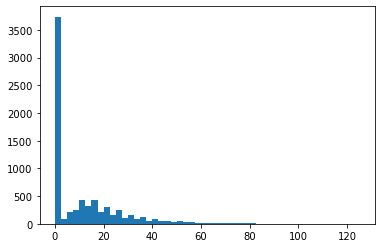

In [17]:
plt.hist(adata[: , 'Xist'].X.toarray(), bins=50)

In [18]:
# add in the Xist metadata to the adata.obs

adata.obs['Female'] = adata[: , 'Xist'].X.toarray() > 0 # make a column in adata.obs to identify female cells
adata.obs['Female_cat']=adata.obs['Female'].astype('category', copy=True) # make a column with category as dtype

In [19]:
### Make a metacolumn that stores male and female cells

adata.obs['Female_str'] = adata.obs['Female'].map(lambda x: str(x).lower() if isinstance(x, bool) else  x)
adata.obs['sex_sample'] = adata.obs['sample'].str.cat(others = adata.obs['Female_str'], sep='_')
adata.obs['sex_sample']=adata.obs['sex_sample'].astype('category', copy=True) # make a column with category as dtype

In [20]:
# make a metacolumn that sto
adata.obs['sex_sample'].value_counts()

ct_true         1663
ct_false        1471
indo_false       756
pIC_false        709
indo_true        691
pIC_true         580
GCSF_true        437
dmPGE2_true      371
GCSF_false       347
dmPGE2_false     327
Name: sex_sample, dtype: int64

In [21]:
plt.rcParams['figure.figsize']=(12,8) #rescale figures

... storing 'assignment' as categorical
... storing 'sample' as categorical
... storing 'Female_str' as categorical
... storing 'feature_types-1' as categorical


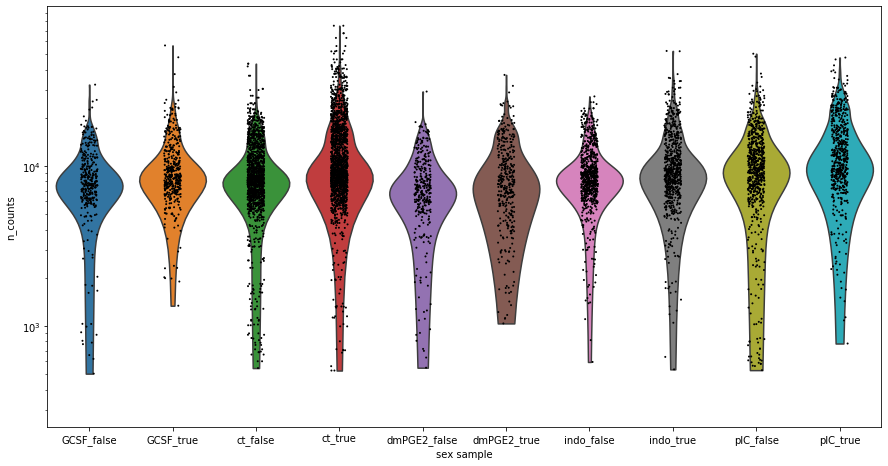

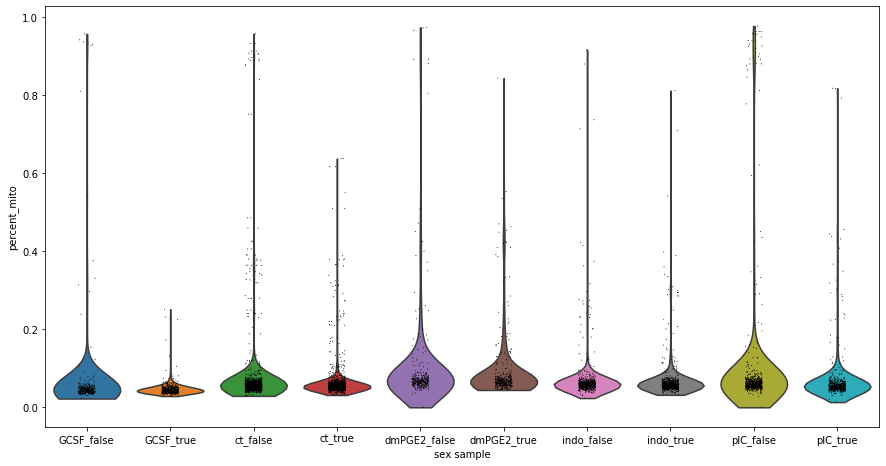

In [22]:
# Quality control - plot QC metrics
#Sample quality plots
t1 = sc.pl.violin(adata, 'n_counts', groupby='sex_sample', size=2, log=True, cut=0)
t2 = sc.pl.violin(adata, 'percent_mito', groupby='sex_sample')

looks like the sequencing depth and the amount of dead cells is pretty similar - interesting trend that male cells tend to have higher mito count - more dead cells?

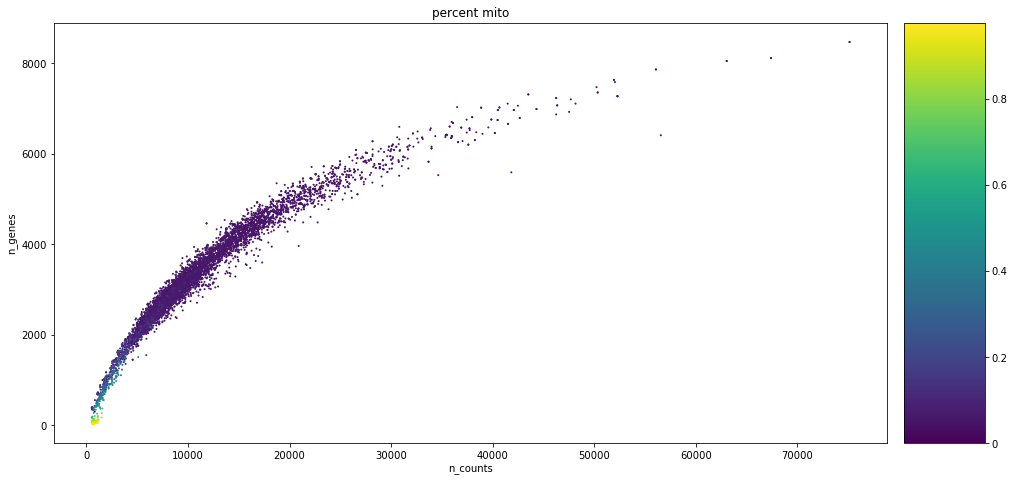

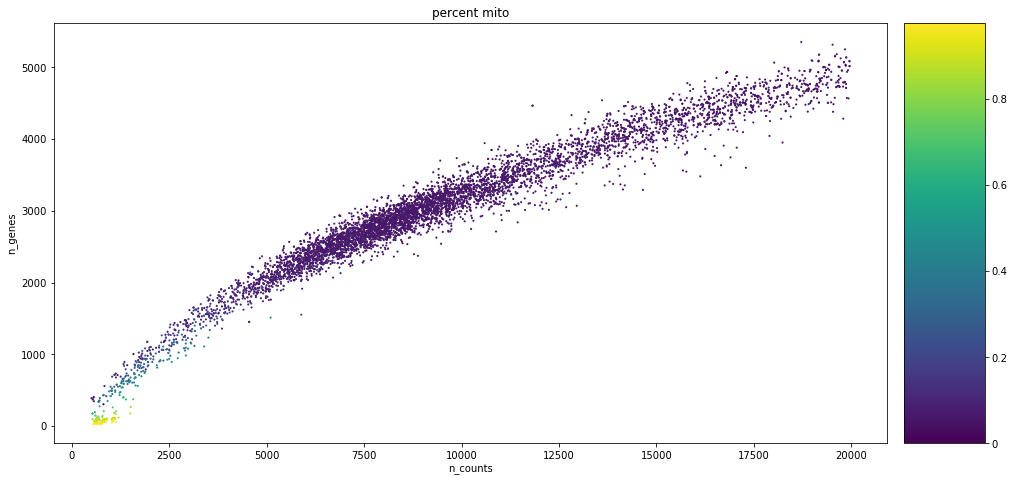

In [23]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='percent_mito')
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<20000], 'n_counts', 'n_genes', color='percent_mito')

the cells that have really high n_counts also have not many genes - so these cells are likely dead

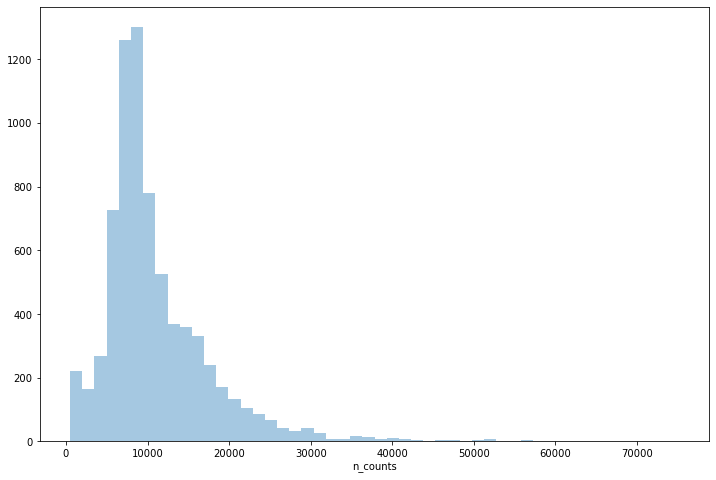

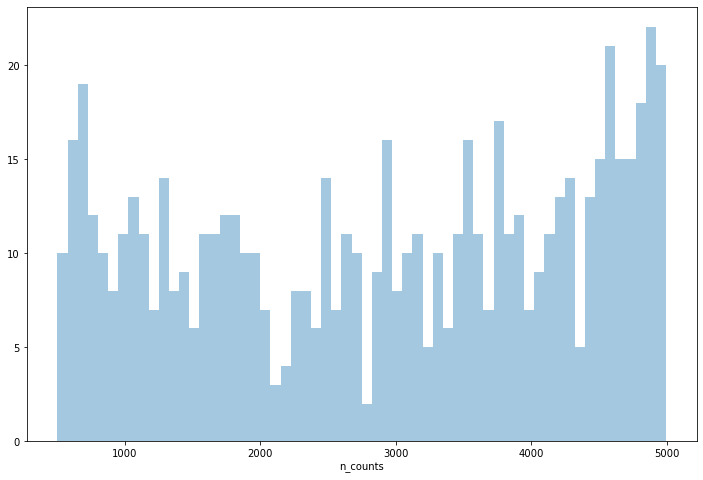

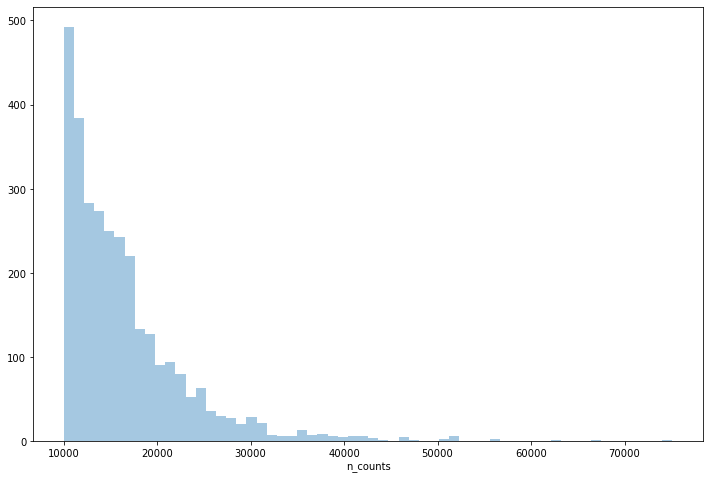

In [24]:
#Thresholding decision: counts
p3 = sb.distplot(adata.obs['n_counts'], kde=False)
plt.show()

p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<5000], kde=False, bins=60)
plt.show()

p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], kde=False, bins=60)
plt.show()

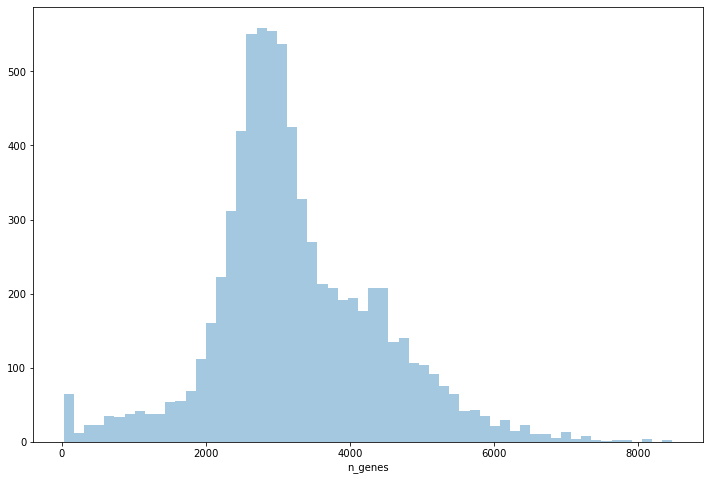

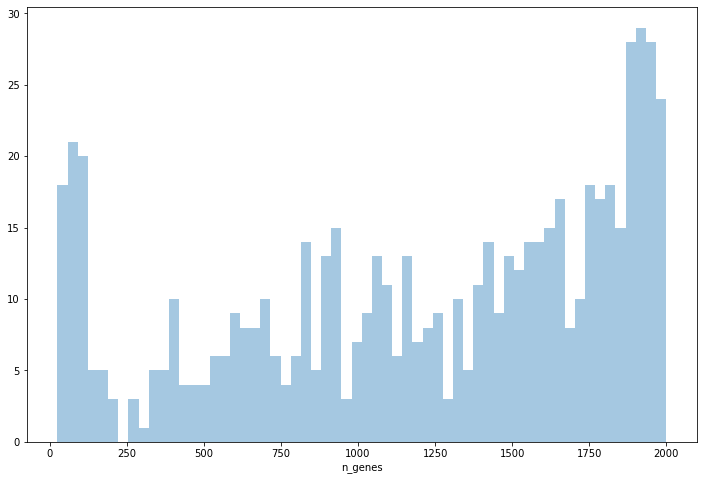

In [25]:
#Thresholding decision: genes
p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<2000], kde=False, bins=60)
plt.show()


In [26]:
# Filter cells according to identified QC thresholds:
# leave filtering criteria relatively loose - can be made more stringent later

print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 3000)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 30000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['percent_mito'] < 0.1]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 1500)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 7352
filtered out 329 cells that have less than 3000 counts
Number of cells after min count filter: 7023
filtered out 145 cells that have more than 30000 counts
Number of cells after max count filter: 6878
Number of cells after MT filter: 6679
filtered out 7 cells that have less than 1500 genes expressed


Trying to set attribute `.obs` of view, copying.


Number of cells after gene filter: 6672


In [27]:
# Filter out genes that are expressed in very few cells

#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 31053
filtered out 17450 genes that are detected in less than 20 cells
Number of genes after cell filter: 13603


In [28]:
# normalize to 10K counts/cell and logtransform
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [29]:
adata.raw = adata

In [30]:
adata

AnnData object with n_obs × n_vars = 6672 × 13603 
    obs: 'assignment', 'batch', 'sample', 'n_counts', 'log_counts', 'n_genes', 'percent_mito', 'Female', 'Female_cat', 'Female_str', 'sex_sample'
    var: 'gene_ids', 'feature_types-1', 'n_cells'
    uns: 'sex_sample_colors', 'log1p'

## 2.2 Batch correction

In [31]:
# make a new column with identifying the batches
adata.obs['batch'] = adata.obs['sample']

adata.obs['batch'] = adata.obs['batch'].apply(lambda x: 'batch1' if x == 'ct' else x)
adata.obs['batch'] = adata.obs['batch'].apply(lambda x: 'batch1' if x == 'indo' else x)
adata.obs['batch'] = adata.obs['batch'].apply(lambda x: 'batch2' if x == 'dmPGE2' else x)
adata.obs['batch'] = adata.obs['batch'].apply(lambda x: 'batch2' if x == 'pIC' else x)
adata.obs['batch'] = adata.obs['batch'].apply(lambda x: 'batch3' if x == 'GCSF' else x)

In [32]:
# ComBat batch correction
sc.pp.combat(adata, key='batch')

... storing 'batch' as categorical


Standardizing Data across genes.

Found 3 batches

Found 0 numerical variables:
	

Fitting L/S model and finding priors

Finding parametric adjustments



/opt/conda/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py:338: RuntimeWarning: divide by zero encountered in true_divide
  change = max((abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max())


Adjusting data



(array([3.230e+02, 0.000e+00, 2.988e+03, 0.000e+00, 0.000e+00, 1.000e+00,
        8.000e+00, 1.200e+01, 5.000e+00, 9.000e+00, 9.000e+00, 2.500e+01,
        1.300e+01, 6.000e+00, 7.000e+00, 3.000e+00, 1.000e+00, 7.000e+00,
        1.200e+01, 4.000e+00, 6.000e+00, 1.300e+01, 1.600e+01, 2.000e+01,
        2.600e+01, 2.900e+01, 2.900e+01, 4.600e+01, 5.100e+01, 7.800e+01,
        9.300e+01, 1.340e+02, 1.530e+02, 2.130e+02, 2.580e+02, 2.670e+02,
        3.010e+02, 3.080e+02, 2.980e+02, 2.610e+02, 1.970e+02, 1.690e+02,
        1.230e+02, 6.100e+01, 4.800e+01, 2.000e+01, 1.200e+01, 5.000e+00,
        2.000e+00, 2.000e+00]),
 array([-1.72944510e-01, -8.81972707e-02, -3.45003133e-03,  8.12972081e-02,
         1.66044447e-01,  2.50791687e-01,  3.35538926e-01,  4.20286166e-01,
         5.05033405e-01,  5.89780644e-01,  6.74527884e-01,  7.59275123e-01,
         8.44022362e-01,  9.28769602e-01,  1.01351684e+00,  1.09826408e+00,
         1.18301132e+00,  1.26775856e+00,  1.35250580e+00,  1.43725304e+

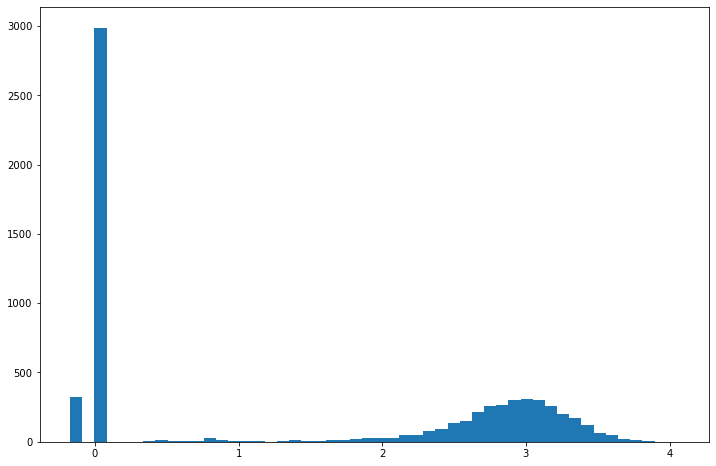

In [33]:
plt.hist(adata[: , 'Xist'].X.toarray(), bins=50)

In [34]:
#make column in adata.obs with corrected Xist

adata.obs['rXist'] = adata[: , 'Xist'].X.toarray() + 0.01 # make a column in adata.obs that stores the actual values of Xist, add 0.01 to get rid of "0" for downstream processin 

#regresses out Xist from adata 
sc.pp.regress_out(adata, ['rXist'])

regressing out ['rXist']
    finished (0:01:18)


# 3) Select variable genes for downstream analysis

In [35]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=2500)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 2499


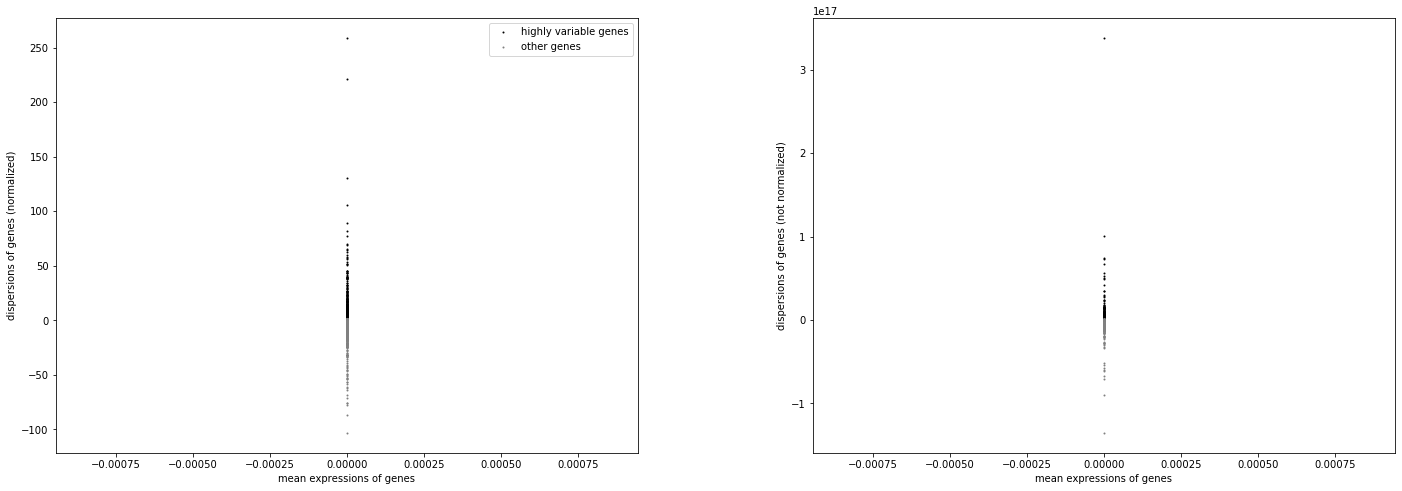

In [36]:
sc.pl.highly_variable_genes(adata)

In [37]:
adata #this now only contains the most variable genes

AnnData object with n_obs × n_vars = 6672 × 13603 
    obs: 'assignment', 'batch', 'sample', 'n_counts', 'log_counts', 'n_genes', 'percent_mito', 'Female', 'Female_cat', 'Female_str', 'sex_sample', 'rXist'
    var: 'gene_ids', 'feature_types-1', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'sex_sample_colors', 'log1p'

In [38]:
#Scale data 
sc.pp.scale(adata, max_value=10)

# Calculate best clustering combination

In [39]:
# run PCA
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:02)


In [40]:
## make loop to save different silhouette scores and Davies Bouldin scores in a dataframe

from __future__ import print_function
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import davies_bouldin_score
from tqdm import tnrange, tqdm_notebook
from time import sleep
import warnings


sc.settings.verbosity = 0   ### suppress output of scanpy
warnings.filterwarnings('ignore') # suppress Warnings
results_df=[]
results_df = pd.DataFrame(columns=['KNN', 'resolution','number_of_clusters', 'sil', 'davie_bould'])

for k in tnrange(5, 60, 5, desc ='1st loop'):
    sc.pp.neighbors(adata, n_neighbors=k, n_pcs=40);
    sc.tl.umap(adata);
    
    for i in tqdm_notebook(range(20, 130, 10), desc ='2nd loop', leave=False):
        j = i/100
        sc.tl.leiden(adata, resolution=j);
        sc.tl.rank_genes_groups(adata, 'leiden')
        silhouette_avg = silhouette_score(adata.obsm['X_pca'], adata.obs['leiden'])
        davies_bouldin_avg = davies_bouldin_score(adata.obsm['X_pca'], adata.obs['leiden'])
        results_df = results_df.append(pd.DataFrame([[k, j, max(adata.obs['leiden']), silhouette_avg, davies_bouldin_avg]], columns=['KNN', 'resolution','number_of_clusters', 'sil', 'davie_bould']))
        sleep(0.01)

In [41]:
results_df['number_of_clusters'] = results_df['number_of_clusters'].astype(float) + 1 
# need to change the object type louvain clusters are saved as object not float
# need to add 1 because it python starts counting at 0 and the total number of clusters is 1 + max

results_df

,KNN,resolution,number_of_clusters,sil,davie_bould
0,5,0.2,8.0,0.022713,2.470774
0,5,0.3,10.0,-0.013364,2.604107
0,5,0.4,10.0,-0.012633,2.642058
0,5,0.5,10.0,0.029595,3.042607
0,5,0.6,10.0,0.005016,2.876131
...,...,...,...,...,...
0,55,0.8,7.0,0.072140,3.109720
0,55,0.9,7.0,0.072274,3.120506
0,55,1.0,7.0,0.072831,3.167125
0,55,1.1,8.0,0.065676,3.258871


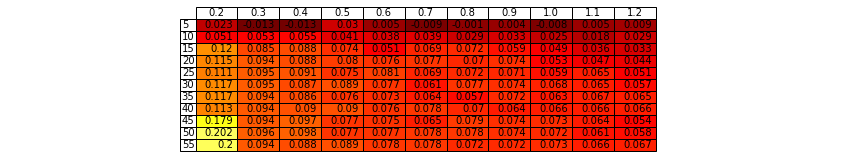

In [42]:
# Make a colored table with the silhouette scores
piv_sil = results_df.pivot(index='KNN', columns='resolution', values='sil')
vals = np.around(piv_sil.values,3) #evenly round to the given number of decimals.

norm = plt.Normalize(vals.min()-0.05, vals.max()+0.05)
colours = plt.cm.hot(norm(vals))

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(411, frameon=False, xticks=[], yticks=[])

the_table=plt.table(cellText=vals, rowLabels=piv_sil.index, colLabels=piv_sil.columns, 
                    colWidths = [0.05]*vals.shape[1], loc='center', 
                    cellColours=colours)
plt.show()

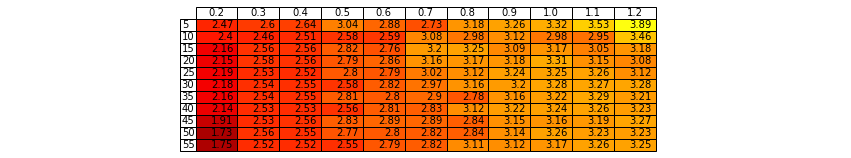

In [43]:
# Make a colored table with the Davies Bouldin scores
piv_DB = results_df.pivot(index='KNN', columns='resolution', values='davie_bould')

vals = np.around(piv_DB.values,2) #evenly round to the given number of decimals.

norm = plt.Normalize(vals.min()-1, vals.max()+1)
colours = plt.cm.hot(norm(vals))


fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(411, frameon=False, xticks=[], yticks=[])

the_table=plt.table(cellText=vals, rowLabels=piv_DB.index, colLabels=piv_DB.columns, 
                    colWidths = [0.05]*vals.shape[1], loc='center', 
                    cellColours=colours)


plt.show()

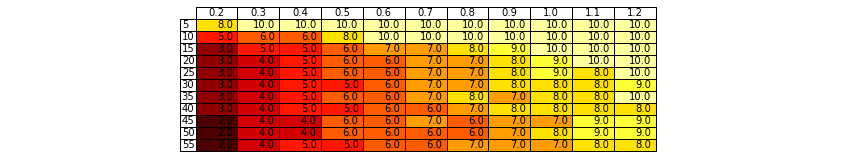

In [44]:
# Make a colored table with the number of clusters
piv_clust = results_df.pivot(index='KNN', columns='resolution', values='number_of_clusters')

vals = np.around(piv_clust.values,2) #evenly round to the given number of decimals.

norm = plt.Normalize(vals.min()-1, vals.max()+1)
colours = plt.cm.hot(norm(vals))


fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(411, frameon=False, xticks=[], yticks=[])

the_table=plt.table(cellText=vals, rowLabels=piv_clust.index, colLabels=piv_clust.columns, 
                    colWidths = [0.05]*vals.shape[1], loc='center', 
                    cellColours=colours)


plt.show()

In [45]:
max_sil = results_df[results_df.groupby('number_of_clusters')['sil'].transform('max') == results_df['sil']].sort_values(by=['number_of_clusters'])
max_sil

,KNN,resolution,number_of_clusters,sil,davie_bould
0,50,0.2,2.0,0.202465,1.727577
0,15,0.2,3.0,0.119856,2.160645
0,50,0.4,4.0,0.097860,2.549899
0,25,0.4,5.0,0.091413,2.523857
0,25,0.6,6.0,0.080917,2.789468
0,30,0.8,7.0,0.077055,3.159219
0,30,0.9,8.0,0.074471,3.202834
0,45,1.1,9.0,0.063934,3.189699
0,35,1.2,10.0,0.065061,3.207410


In [46]:
min_db = results_df[results_df.groupby('number_of_clusters')['davie_bould'].transform('min') == results_df['davie_bould']].sort_values(by=['number_of_clusters'])
min_db

,KNN,resolution,number_of_clusters,sil,davie_bould
0,50,0.2,2.0,0.202465,1.727577
0,40,0.2,3.0,0.113353,2.144969
0,55,0.3,4.0,0.093980,2.517228
0,10,0.2,5.0,0.051322,2.398701
0,10,0.3,6.0,0.053130,2.463302
0,15,0.6,7.0,0.050833,2.761350
0,5,0.2,8.0,0.022713,2.470774
0,15,0.9,9.0,0.058582,3.085453
0,10,0.6,10.0,0.037729,2.593646


<function matplotlib.pyplot.show(*args, **kw)>

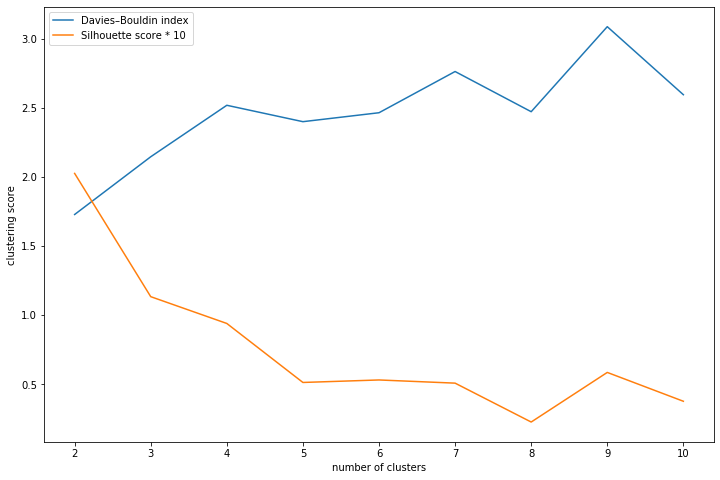

In [47]:
# plot the top value for each cluster

plt.plot(min_db['number_of_clusters'], min_db['davie_bould'])
plt.plot(max_sil['number_of_clusters'], min_db['sil'] * 10)
plt.legend(['Davies–Bouldin index','Silhouette score * 10'])
plt.xlabel('number of clusters')
plt.ylabel('clustering score')
plt.show

In [48]:
results_df[results_df['number_of_clusters'] == 6].sort_values('sil', ascending=False) 

,KNN,resolution,number_of_clusters,sil,davie_bould
0,25,0.6,6.0,0.080917,2.789468
0,20,0.5,6.0,0.080247,2.793315
0,45,0.8,6.0,0.078654,2.841580
0,50,0.8,6.0,0.078474,2.835416
0,40,0.7,6.0,0.078400,2.831812
0,55,0.7,6.0,0.078114,2.817056
0,55,0.6,6.0,0.078035,2.794391
0,50,0.7,6.0,0.077993,2.824297
0,50,0.5,6.0,0.077492,2.772051
0,50,0.6,6.0,0.077296,2.804888


In [49]:
results_df[results_df['number_of_clusters'] == 7].sort_values('sil', ascending=False) 

,KNN,resolution,number_of_clusters,sil,davie_bould
0,30,0.8,7.0,0.077055,3.159219
0,20,0.7,7.0,0.076902,3.164238
0,50,0.9,7.0,0.073569,3.140984
0,45,0.9,7.0,0.073532,3.149037
0,55,1.0,7.0,0.072831,3.167125
0,45,1.0,7.0,0.072672,3.158140
0,55,0.9,7.0,0.072274,3.120506
0,55,0.8,7.0,0.072140,3.109720
0,25,0.8,7.0,0.071563,3.115411
0,35,0.9,7.0,0.071505,3.157510


In [50]:
results_df[results_df['number_of_clusters'] == 8].sort_values('sil', ascending=False) 

,KNN,resolution,number_of_clusters,sil,davie_bould
0,30,0.9,8.0,0.074471,3.202834
0,20,0.9,8.0,0.074324,3.183971
0,15,0.8,8.0,0.072419,3.245378
0,50,1.0,8.0,0.071680,3.261649
0,25,0.9,8.0,0.071390,3.237623
0,30,1.0,8.0,0.067638,3.276044
0,35,1.1,8.0,0.067185,3.285143
0,55,1.2,8.0,0.066507,3.254545
0,40,1.1,8.0,0.066465,3.256014
0,40,1.0,8.0,0.065817,3.235505


In [51]:
results_df[results_df['number_of_clusters'] == 5].sort_values('sil', ascending=False) 

,KNN,resolution,number_of_clusters,sil,davie_bould
0,25,0.4,5.0,0.091413,2.523857
0,40,0.5,5.0,0.090069,2.559577
0,40,0.4,5.0,0.089867,2.526163
0,30,0.5,5.0,0.089235,2.576065
0,55,0.5,5.0,0.089008,2.554438
0,55,0.4,5.0,0.088417,2.521296
0,20,0.4,5.0,0.088357,2.558930
0,15,0.4,5.0,0.087553,2.563873
0,30,0.4,5.0,0.086593,2.549191
0,35,0.4,5.0,0.086234,2.552141


## plot different KNN + resolutions and see how the UMAP graphs actually look like

#### Leiden 5 clusters 15 KNN, 0.4 resolution

In [52]:
plt.rcParams['figure.figsize']=(4,4) #rescale figures

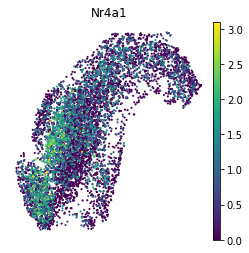

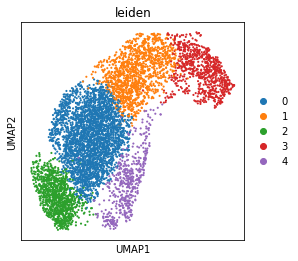

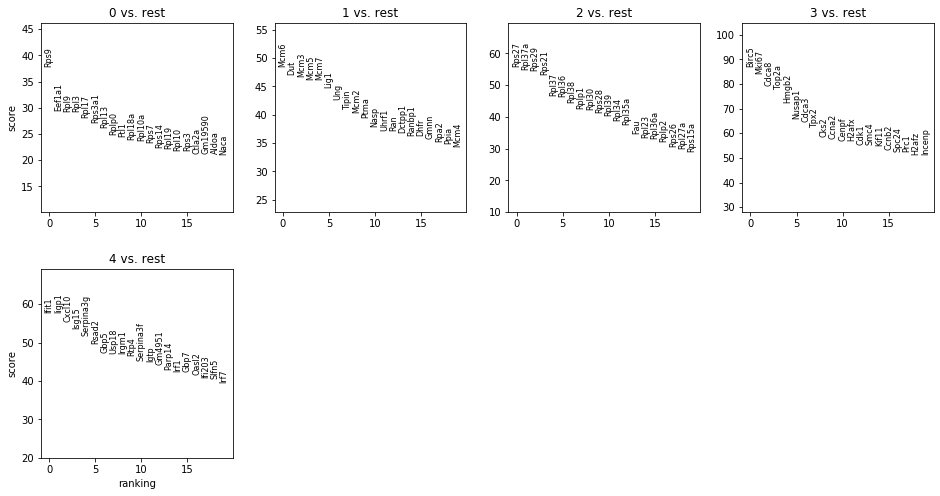

In [53]:
# redo the umap with different neigborhoods

sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['Nr4a1'], legend_loc='on data', frameon=False)
sc.tl.leiden(adata, resolution=0.4)
sc.pl.umap(adata, color=['leiden'])
sc.tl.rank_genes_groups(adata, 'leiden')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

#### Leiden 6 clusters 45 KNN, 0.6 resolution

In [54]:
plt.rcParams['figure.figsize']=(4,4) #rescale figures

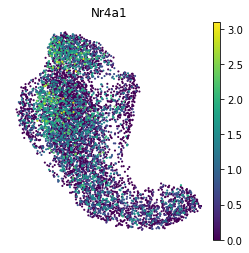

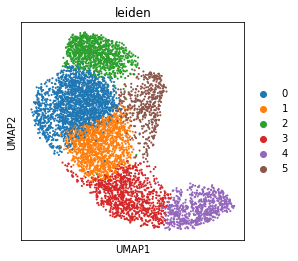

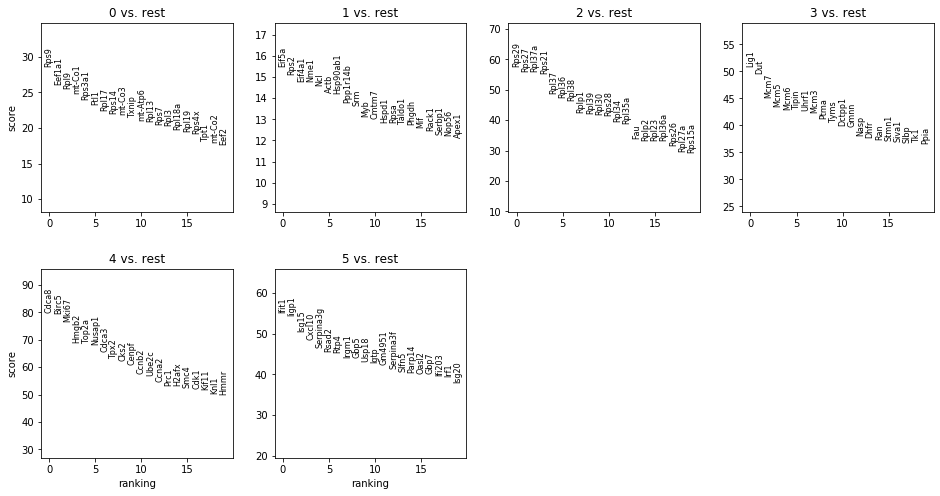

In [55]:
# redo the umap with different neigborhoods

sc.pp.neighbors(adata, n_neighbors=45, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['Nr4a1'], legend_loc='on data', frameon=False)
sc.tl.leiden(adata, resolution=0.6)
sc.pl.umap(adata, color=['leiden'])
sc.tl.rank_genes_groups(adata, 'leiden')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

#### Leiden 7 clusters 35 KNN, 0.7 resolution

In [56]:
plt.rcParams['figure.figsize']=(4,4) #rescale figures

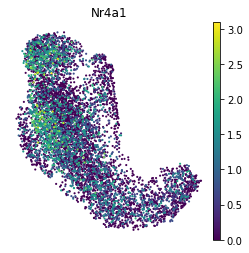

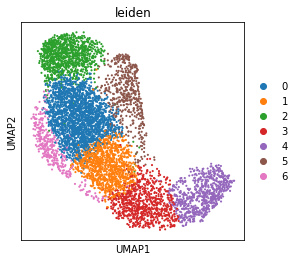

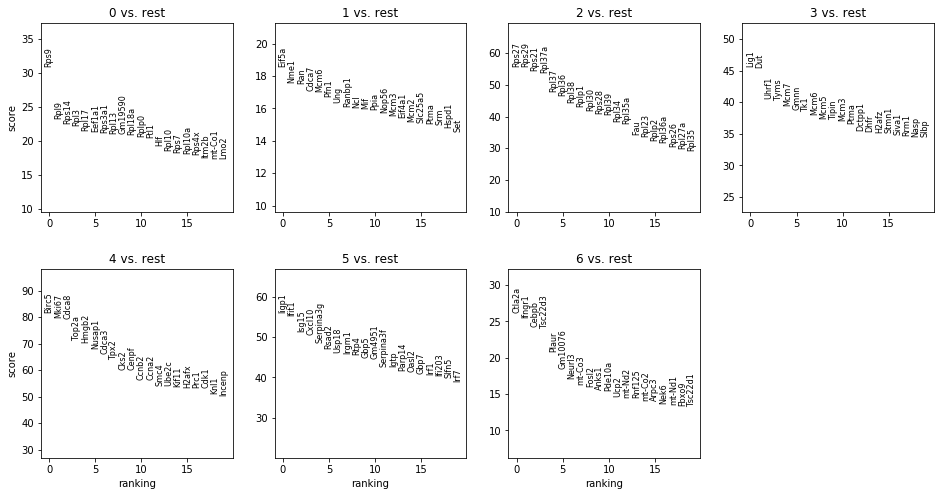

In [57]:
# redo the umap with different neigborhoods

sc.pp.neighbors(adata, n_neighbors=35, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['Nr4a1'], legend_loc='on data', frameon=False)
sc.tl.leiden(adata, resolution=0.7)
sc.pl.umap(adata, color=['leiden'])
sc.tl.rank_genes_groups(adata, 'leiden')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

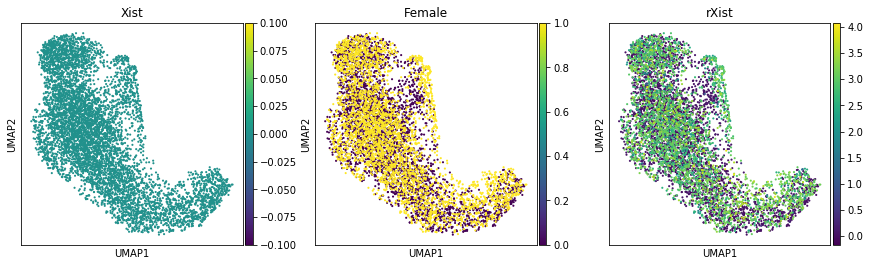

In [58]:
sc.pl.umap(adata, color=['Xist', 'Female', 'rXist'], use_raw=False )

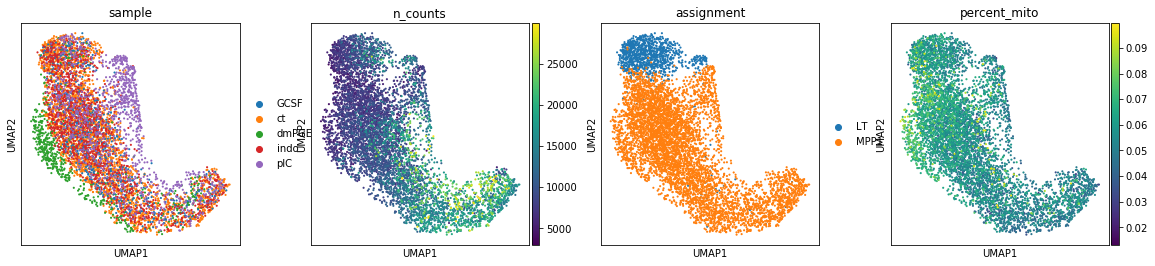

In [59]:
sc.pl.umap(adata, color=['sample', 'n_counts', 'assignment', 'percent_mito'], use_raw=False )

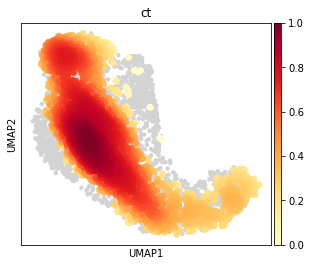

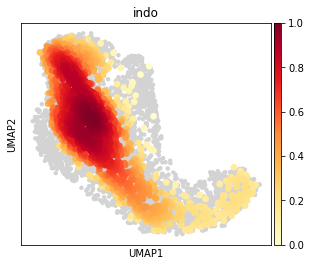

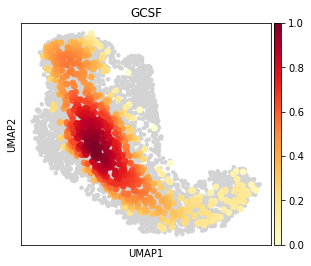

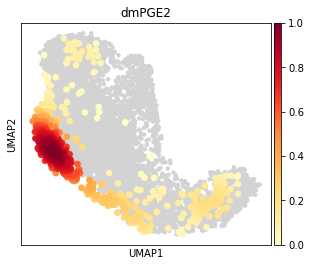

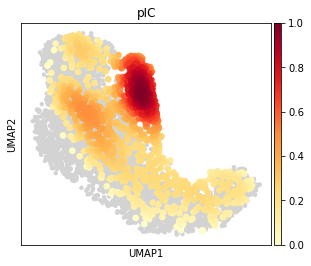

In [60]:
#see where samples localize
import scanpy as sc

#Plot the density
sc.tl.embedding_density(adata, basis='umap', groupby='sample')

adata.obs['sample'].value_counts()
sc.pl.embedding_density(adata, basis='umap', key='umap_density_sample', group='ct')
sc.pl.embedding_density(adata, basis='umap', key='umap_density_sample', group='indo')
sc.pl.embedding_density(adata, basis='umap', key='umap_density_sample', group='GCSF')
sc.pl.embedding_density(adata, basis='umap', key='umap_density_sample', group='dmPGE2')
sc.pl.embedding_density(adata, basis='umap', key='umap_density_sample', group='pIC')

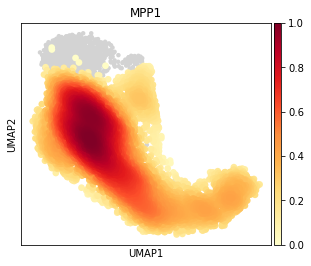

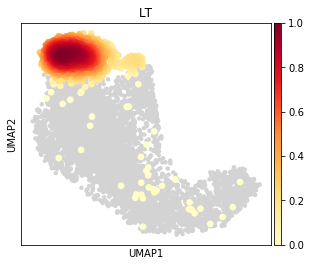

In [61]:
#Plot the density
sc.tl.embedding_density(adata, basis='umap', groupby='assignment')

adata.obs['assignment'].value_counts()
sc.pl.embedding_density(adata, basis='umap', key='umap_density_assignment', group='MPP1')
sc.pl.embedding_density(adata, basis='umap', key='umap_density_assignment', group='LT')

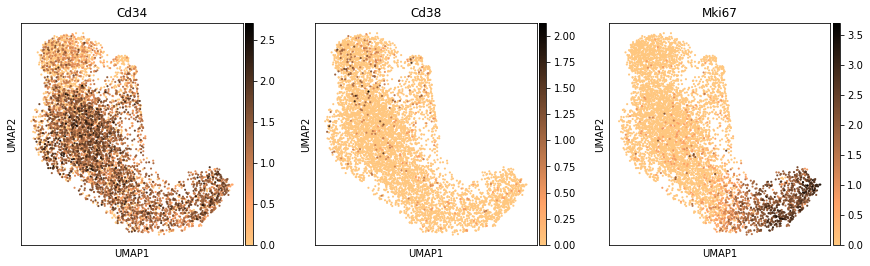

In [62]:
sc.pl.umap(adata, color=['Cd34', 'Cd38', 'Mki67'], use_raw=True, cmap='copper_r')

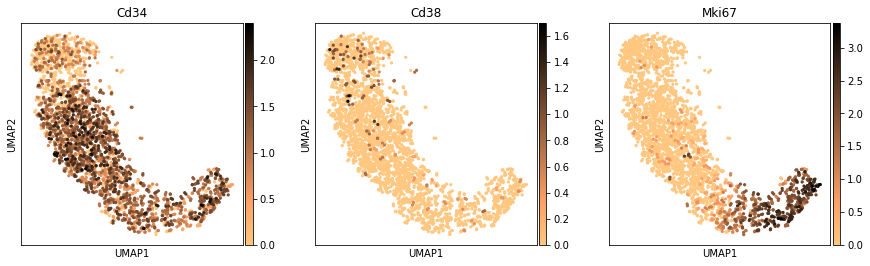

In [63]:
sc.pl.umap(adata[adata.obs['sample'] =='ct'], color=['Cd34', 'Cd38', 'Mki67'], use_raw=True, cmap='copper_r')

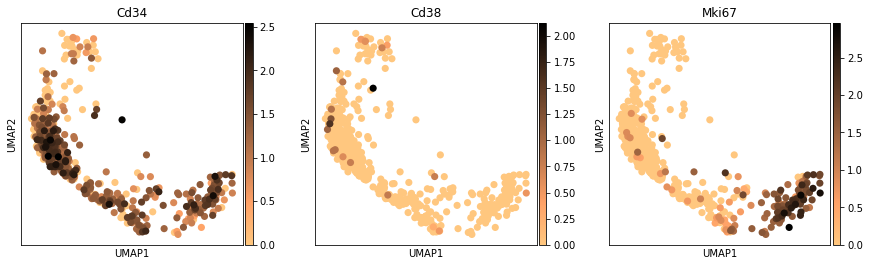

In [64]:
sc.pl.umap(adata[adata.obs['sample'] =='dmPGE2'], color=['Cd34', 'Cd38', 'Mki67'], use_raw=True, cmap='copper_r')

In [65]:
adata.obs

,assignment,batch,sample,n_counts,log_counts,n_genes,percent_mito,Female,Female_cat,Female_str,sex_sample,rXist,leiden,umap_density_sample,umap_density_assignment
AAAGAACTCCACGGAC-0,LT,batch1,ct,6740.0,8.816557,2441,0.076205,True,True,true,ct_true,2.846412,2,0.688444,0.904938
AAAGGGCAGTAGATCA-0,LT,batch1,ct,10724.0,9.280613,3285,0.050336,True,True,true,ct_true,3.325537,2,0.661310,0.705198
AAATGGAAGGTAGTCG-0,LT,batch1,ct,6209.0,8.734077,2151,0.058123,False,False,false,ct_false,0.010470,2,0.632850,0.737537
AAATGGACAATTCGTG-0,LT,batch1,ct,15737.0,9.664087,4046,0.045039,True,True,true,ct_true,2.223813,2,0.165103,0.218490
AACAGGGGTCGGATTT-0,LT,batch1,ct,10879.0,9.294774,3182,0.046319,False,False,false,ct_false,0.010470,2,0.108697,0.134488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGAGAGCATGAAT-1-1,MPP1,batch2,pIC,12566.0,9.439227,3641,0.057111,False,False,false,pIC_false,0.081949,1,0.083413,0.560622
TTTGGTTAGGTGTGAC-1-1,MPP1,batch2,pIC,25786.0,10.157897,5512,0.066876,True,True,true,pIC_true,3.605320,4,0.225461,0.167393
TTTGGTTCACTGTGAT-1-1,MPP1,batch2,pIC,8678.0,9.069238,2920,0.095002,True,True,true,pIC_true,3.761446,3,0.231771,0.508562
TTTGGTTTCTATCACT-1-1,MPP1,batch2,pIC,9132.0,9.120197,2716,0.052528,True,True,true,pIC_true,3.201379,5,0.678011,0.158939


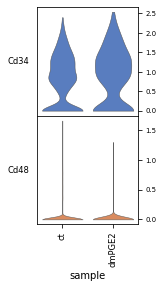

In [66]:
sc.pl.stacked_violin(adata[(adata.obs['sample']=='ct') |
                           (adata.obs['sample']=='dmPGE2')
                           ],
                         ['Cd34', 'Cd48'], figsize=(2,4), log=False, swap_axes=True, 
                          groupby='sample')

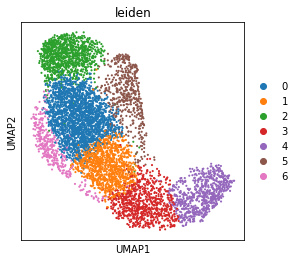

In [67]:
sc.pl.umap(adata, color = 'leiden')

In [68]:
adata.rename_categories('leiden', ['Primed', 'Metabolism', 'Stem cell', 'Cell-cycle-2', 'Cell-cycle-1', 
                                   'Interferon', 'Acute-Activation'])

In [69]:
abs_v_ct = pd.pivot_table(adata.obs[adata.obs['sample']=='ct'], values='sex_sample', index=['leiden'],columns=['assignment'], aggfunc=[len])
abs_v_ct = abs_v_ct.fillna(0) #replaces all NaNs with 0
abs_v_ct.columns = abs_v_ct.columns.droplevel(0) # drops columnlevel (=len)
#abs_v.to_csv('./write/MPP_cell_numbers.csv', index=True, header=True)
abs_v_ct

assignment,LT,MPP1
leiden,,
Primed,1,1024
Metabolism,1,574
Stem cell,474,44
Cell-cycle-2,9,378
Cell-cycle-1,6,314
Interferon,2,28


In [70]:
abs_v = pd.pivot_table(adata.obs[(adata.obs['sample']=='dmPGE2')], values='sex_sample', index=['leiden'],columns=['assignment'], aggfunc=[len])
abs_v = abs_v.fillna(0) #replaces all NaNs with 0
abs_v.columns = abs_v.columns.droplevel(0) # drops columnlevel (=len)
#abs_v.to_csv('./write/MPP_cell_numbers.csv', index=True, header=True)
abs_v

assignment,LT,MPP1
leiden,,
Primed,1.0,24.0
Metabolism,0.0,15.0
Stem cell,33.0,11.0
Cell-cycle-2,1.0,74.0
Cell-cycle-1,0.0,77.0
Acute-Activation,2.0,348.0


In [71]:
mrg = pd.merge(abs_v_ct, abs_v, left_index=True, right_index=True, how='outer')

In [72]:
mrg = mrg.fillna(0) #replaces all NaNs with 0
#mrg.columns = mrg.columns.droplevel(1) # drops columnlevel (=len)
mrg.columns = ['HSC_ct', 'MPP1_ct', 'HSC_dmPGE2', 'MPP1_dmPGE2'] 
mrg

,HSC_ct,MPP1_ct,HSC_dmPGE2,MPP1_dmPGE2
leiden,,,,
Primed,1.0,1024.0,1.0,24.0
Metabolism,1.0,574.0,0.0,15.0
Stem cell,474.0,44.0,33.0,11.0
Cell-cycle-2,9.0,378.0,1.0,74.0
Cell-cycle-1,6.0,314.0,0.0,77.0
Interferon,2.0,28.0,0.0,0.0
Acute-Activation,0.0,0.0,2.0,348.0


In [77]:
mrg = mrg.reindex(['Stem cell', 'Primed', 'Metabolism', 
                   'Cell-cycle-1', 'Cell-cycle-2','Interferon', 'Acute-Activation'])

def_color = ['#1f77b4','#b5bd61', '#279e68', '#8c564b', 
                               '#C18F5A', '#aa40fc', '#d62728']

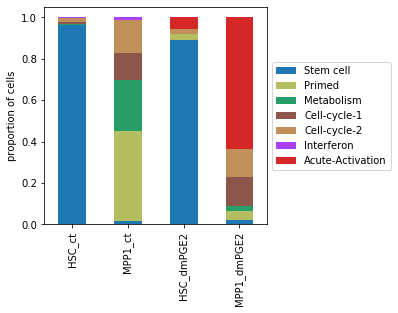

In [78]:
percent_abs_v = mrg.iloc[:,0:5].div(mrg.sum(axis=0), axis=1)
percent_abs_v.T.plot.bar(stacked=True, color = def_color)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel("proportion of cells")
#plt.grid(b=None) # turns off gridlines
plt.savefig('./figures/dmPGE2_surface_switch.pdf', bbox_inches = "tight")

In [79]:
%pip list

Package                Version            
---------------------- -------------------
alembic                1.3.0              
anndata                0.7.1              
async-generator        1.10               
attrs                  19.3.0             
backcall               0.1.0              
beautifulsoup4         4.8.1              
bleach                 3.1.0              
blinker                1.4                
bokeh                  1.3.4              
cellbrowser            0.7.7              
certifi                2020.4.5.1         
certipy                0.1.3              
cffi                   1.13.2             
chardet                3.0.4              
Click                  7.0                
cloudpickle            1.2.2              
conda                  4.7.12             
conda-package-handling 1.6.0              
cryptography           2.8                
cycler                 0.10.0             
Cython                 0.29.14            
cytoolz    